In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
%matplotlib inline

Getting and cleaning data


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/daily_IBM_withscaledOBVandClosed - daily_IBM (1).csv')

# The used csv file is in the github repo
# This csv file has been preprocessed using Google Sheets and relevant formulas for RSI and OBV as mentioned in the presentation

In [ ]:
df1['timestamp']=pd.to_datetime(df1['timestamp'],errors='coerce')
df1.set_index('timestamp', inplace=True)
df1.head()

,open,high,low,close,volume,OBV,closescaled,OBVscaled,Y_value
timestamp,,,,,,,,,
2022-01-28,133.19,134.5300,131.790,134.50,5471497,1004602994,0.494183,0.519423,0.000000
2022-01-27,133.66,134.7500,132.080,132.52,5499566,999131497,0.481864,0.508160,0.494183
2022-01-26,136.47,137.0700,133.130,134.26,8335992,1004631063,0.492690,0.519481,0.481864
2022-01-25,129.14,137.3361,128.300,136.10,19715698,1012967055,0.504137,0.536639,0.492690
2022-01-24,127.99,129.1500,124.193,128.82,13777648,993251357,0.458844,0.496057,0.504137


In [ ]:
def get_RSI(relevant_data, input_date_index):
  gain = 0
  loss = 0
  i = relevant_data['close'].iloc[0]
  for j in relevant_data['close'][1:15]:
    if j > i:
      loss += (j-i)/j
      #print(100*(-j+i)/j)
    if j < i:
      gain += (i-j)/j
    i = j
  RSI = 1-(1/(1+(gain/loss)))
  return RSI
df1['RSI'] = df1['close']
for i in range(len(df1)-18):
  df1['RSI'].iloc[i] = get_RSI(df1.iloc[i:i+15], i)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df2 = df1[:-20]
df2 = df2.drop(df2.columns[[0,1,2,3,4,5]], axis=1)
df2.to_csv("referencedfIBM.csv")

Making train and test data

In [ ]:
scaler = MinMaxScaler()
X=scaler.fit_transform(df2[['closescaled', 'OBVscaled','RSI']])
y=scaler.fit_transform(df2[['Y_value']])

In [ ]:
X

array([[0.49418279, 0.51942283, 0.50297635],
       [0.481864  , 0.50816031, 0.44522067],
       [0.4926896 , 0.51948061, 0.42473475],
       ...,
       [0.31232502, 0.36579366, 0.70831637],
       [0.30081503, 0.3529968 , 0.63326905],
       [0.29857525, 0.34201236, 0.67413928]])

In [ ]:
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
print(len(train_X), len(test_X))
print(len(train_y),len(test_y))

4462 1116
4462 1116


In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4462, 1, 3) (4462, 1) (1116, 1, 3) (1116, 1)


Model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
140/140 - 3s - loss: 0.2482 - val_loss: 0.0690 - 3s/epoch - 22ms/step
Epoch 2/150
140/140 - 0s - loss: 0.0941 - val_loss: 0.0701 - 414ms/epoch - 3ms/step
Epoch 3/150
140/140 - 0s - loss: 0.0881 - val_loss: 0.0660 - 439ms/epoch - 3ms/step
Epoch 4/150
140/140 - 0s - loss: 0.0829 - val_loss: 0.0635 - 435ms/epoch - 3ms/step
Epoch 5/150
140/140 - 0s - loss: 0.0802 - val_loss: 0.0617 - 410ms/epoch - 3ms/step
Epoch 6/150
140/140 - 0s - loss: 0.0776 - val_loss: 0.0603 - 416ms/epoch - 3ms/step
Epoch 7/150
140/140 - 0s - loss: 0.0745 - val_loss: 0.0581 - 399ms/epoch - 3ms/step
Epoch 8/150
140/140 - 0s - loss: 0.0715 - val_loss: 0.0560 - 380ms/epoch - 3ms/step
Epoch 9/150
140/140 - 0s - loss: 0.0678 - val_loss: 0.0552 - 391ms/epoch - 3ms/step
Epoch 10/150
140/140 - 0s - loss: 0.0639 - val_loss: 0.0541 - 377ms/epoch - 3ms/step
Epoch 11/150
140/140 - 0s - loss: 0.0597 - val_loss: 0.0524 - 410ms/epoch - 3ms/step
Epoch 12/150
140/140 - 0s - loss: 0.0547 - val_loss: 0.0515 - 401ms/epoch - 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


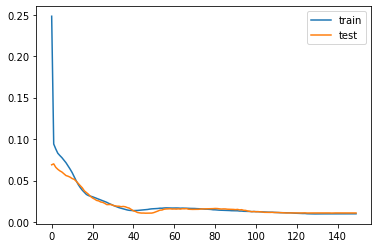

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Inverting from scaled to actual values

In [ ]:
minclose = min(df1['close'])
maxclose = max(df1['close'])
def get_actual(scaled, min, max):
  return min + scaled*(max-min)

Results

In [ ]:
yhat = model.predict(test_X)

In [ ]:
actuals_pred = get_actual(yhat, minclose, maxclose)
actuals_true = get_actual(test_y, minclose, maxclose)
rmse = sqrt(mean_squared_error(actuals_true, actuals_pred))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(actuals_true, actuals_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 2.410
Test MAE: 1.743


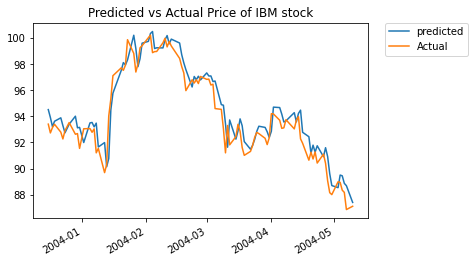

In [ ]:
test_dates=np.array(df2.index)[train_size:len(y)]
fig, ax = plt.subplots(1)
ax.plot(pd.to_datetime(test_dates[:100]).to_pydatetime(),actuals_pred[:100],label="predicted")
ax.plot(pd.to_datetime(test_dates[:100]).to_pydatetime(),actuals_true[:100], label="Actual")
fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Predicted vs Actual Price of IBM stock')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
input_full = np.array(df2[['closescaled', 'OBVscaled','RSI']])[1:]
input_full = input_full.reshape((input_full.shape[0], 1, input_full.shape[1]))

In [ ]:
full_predicted = model.predict([input_full])

In [ ]:
full_pred_inv = get_actual(full_predicted, minclose, maxclose)
full_true_inv = get_actual(y[1:], minclose, maxclose)

In [ ]:
model.save('finalmodelnew')

In [ ]:
import tensorflow as tf
model3 = tf.keras.models.load_model('finalmodelnew')

In [ ]:
!zip -r /content/finalmodelnewzip.zip /content/finalmodelnew